In [1]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

In [2]:
data_path = "/Users/praneetgogoi/Documents/brain-mri-model/brain-mri/train"

image_paths = []
labels_list = []

for class_name in os.listdir(data_path):
    class_path = os.path.join(data_path, class_name)
    if not os.path.isdir(class_path):
        continue
    
    for img_file in os.listdir(class_path):
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(class_path, img_file))
            labels_list.append(class_name)

df = pd.DataFrame({'image_path': image_paths, 'label': labels_list})

print(f"Total Images: {len(df)}")
print(f"Number of Classes: {df['label'].nunique()}")
print("\nClass Distribution:")
class_dist = df['label'].value_counts()
print(class_dist)

Total Images: 1400
Number of Classes: 5

Class Distribution:
label
fukuyama_muscular_dystrophy         280
pachygyria_cerebellar_hypoplasia    280
walker_warburg_syndrome             280
moyamoya_disease                    280
hallervorden_spatz_disease          280
Name: count, dtype: int64


In [3]:
from sklearn.model_selection import train_test_split
strat = df['label']
train_df, temp_df = train_test_split(
    df, 
    train_size=0.8, 
    shuffle=True, 
    random_state=42, 
    stratify=strat
)

strat = temp_df['label']
val_df, test_df = train_test_split(
    temp_df, 
    train_size=0.5, 
    shuffle=True, 
    random_state=42, 
    stratify=strat
)

print(f"\nTraining Set: {train_df.shape[0]} images")
print(f"Validation Set: {val_df.shape[0]} images")
print(f"Test Set: {test_df.shape[0]} images")


Training Set: 1120 images
Validation Set: 140 images
Test Set: 140 images


In [4]:
IMG_SIZE = (300, 300)
BATCH_SIZE = 16

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

class_indices = train_generator.class_indices
class_names = list(class_indices.keys())
num_classes = len(class_names)

print(f"\nNumber of classes: {num_classes}")
print(f"Class names: {class_names}")

Found 1120 validated image filenames belonging to 5 classes.
Found 140 validated image filenames belonging to 5 classes.
Found 140 validated image filenames belonging to 5 classes.

Number of classes: 5
Class names: ['fukuyama_muscular_dystrophy', 'hallervorden_spatz_disease', 'moyamoya_disease', 'pachygyria_cerebellar_hypoplasia', 'walker_warburg_syndrome']


In [5]:
base_model = EfficientNetB3(
    weights='imagenet',
    include_top=False,
    input_shape=(300, 300, 3),
    pooling='avg'
)

base_model.trainable = True

for layer in base_model.layers[:200]: 
    layer.trainable = False
for layer in base_model.layers[200:]: 
    layer.trainable = True

x = base_model.output
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"\nModel Summary:")
model.summary()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 300, 300,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 300, 300,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 300, 300,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 301, 301,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 150, 150,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 150, 150,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 150, 150,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 150, 150,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │        960 │ block1a_se_excit

 Total params: 11,217,716 (42.79 MB)

 Trainable params: 10,252,435 (39.11 MB)

 Non-trainable params: 965,281 (3.68 MB)

In [6]:
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        mode='max'
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_efficientnetb3_tf_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    )
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)

val_loss, val_accuracy = model.evaluate(val_generator, verbose=0)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 912ms/step - accuracy: 0.2377 - loss: 2.0229

70/70 ━━━━━━━━━━━━━━━━━━━━ 84s 984ms/step - accuracy: 0.2589 - loss: 1.9547 - val_accuracy: 0.2071 - val_loss: 1.6105 - learning_rate: 1.0000e-04
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.3402 - loss: 1.7301 - val_accuracy: 0.1929 - val_loss: 1.6113 - learning_rate: 1.0000e-04
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3646 - loss: 1.6135

70/70 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.3661 - loss: 1.6164 - val_accuracy: 0.2214 - val_loss: 1.5406 - learning_rate: 1.0000e-04
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3785 - loss: 1.6165

70/70 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.3848 - loss: 1.5641 - val_accuracy: 0.2786 - val_loss: 1.4802 - learning_rate: 1.0000e-04
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4412 - loss: 1.4266

70/70 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.4321 - loss: 1.4316 - val_accuracy: 0.3857 - val_loss: 1.3251 - learning_rate: 1.0000e-04
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4234 - loss: 1.3928

70/70 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.4473 - loss: 1.3768 - val_accuracy: 0.5214 - val_loss: 1.0994 - learning_rate: 1.0000e-04
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5187 - loss: 1.2312

70/70 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.5098 - loss: 1.2578 - val_accuracy: 0.6429 - val_loss: 0.8658 - learning_rate: 1.0000e-04
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.4938 - loss: 1.2575 - val_accuracy: 0.6429 - val_loss: 0.8478 - learning_rate: 1.0000e-04
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5308 - loss: 1.1264

70/70 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.5339 - loss: 1.1425 - val_accuracy: 0.6571 - val_loss: 0.7911 - learning_rate: 1.0000e-04
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5596 - loss: 1.0846

70/70 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.5580 - loss: 1.0961 - val_accuracy: 0.6929 - val_loss: 0.8149 - learning_rate: 1.0000e-04
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.5884 - loss: 1.0573 - val_accuracy: 0.6857 - val_loss: 0.7605 - learning_rate: 1.0000e-04
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5826 - loss: 1.0712

70/70 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.5964 - loss: 1.0523 - val_accuracy: 0.7857 - val_loss: 0.5926 - learning_rate: 1.0000e-04
Epoch 13/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.6000 - loss: 0.9874 - val_accuracy: 0.7786 - val_loss: 0.5980 - learning_rate: 1.0000e-04
Epoch 14/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.6348 - loss: 0.9572 - val_accuracy: 0.7357 - val_loss: 0.6932 - learning_rate: 1.0000e-04
Epoch 15/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.6643 - loss: 0.8774 - val_accuracy: 0.7571 - val_loss: 0.5748 - learning_rate: 1.0000e-04
Epoch 16/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6449 - loss: 0.9786

70/70 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.6509 - loss: 0.9288 - val_accuracy: 0.8143 - val_loss: 0.4825 - learning_rate: 1.0000e-04
Epoch 17/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.6580 - loss: 0.8556 - val_accuracy: 0.7500 - val_loss: 0.7327 - learning_rate: 1.0000e-04
Epoch 18/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.6661 - loss: 0.8756 - val_accuracy: 0.8071 - val_loss: 0.4555 - learning_rate: 1.0000e-04
Epoch 19/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6777 - loss: 0.7947

70/70 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.6723 - loss: 0.8178 - val_accuracy: 0.8571 - val_loss: 0.3803 - learning_rate: 1.0000e-04
Epoch 20/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.7036 - loss: 0.7605 - val_accuracy: 0.8071 - val_loss: 0.4563 - learning_rate: 1.0000e-04
Epoch 21/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.7330 - loss: 0.7271 - val_accuracy: 0.8571 - val_loss: 0.3862 - learning_rate: 1.0000e-04
Epoch 22/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7407 - loss: 0.6834

70/70 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.7464 - loss: 0.6687 - val_accuracy: 0.8643 - val_loss: 0.4067 - learning_rate: 1.0000e-04
Epoch 23/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.7429 - loss: 0.6752 - val_accuracy: 0.8071 - val_loss: 0.4815 - learning_rate: 1.0000e-04
Epoch 24/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7345 - loss: 0.6410

70/70 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.7348 - loss: 0.6601 - val_accuracy: 0.8857 - val_loss: 0.3269 - learning_rate: 1.0000e-04
Epoch 25/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.7634 - loss: 0.6242 - val_accuracy: 0.8714 - val_loss: 0.3097 - learning_rate: 1.0000e-04
Epoch 26/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.7696 - loss: 0.6134 - val_accuracy: 0.8643 - val_loss: 0.3402 - learning_rate: 1.0000e-04
Epoch 27/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.7786 - loss: 0.6160 - val_accuracy: 0.8786 - val_loss: 0.3264 - learning_rate: 1.0000e-04
Epoch 28/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.7714 - loss: 0.6187 - val_accuracy: 0.8429 - val_loss: 0.4461 - learning_rate: 1.0000e-04
Epoch 29/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.7723 - loss: 0.6009 - val_accuracy: 0.8571 - val_loss: 0.4527 - learning_rate: 1.0000e-04
Epoch 30/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8259 - loss: 0.528

70/70 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.8152 - loss: 0.5051 - val_accuracy: 0.8929 - val_loss: 0.3266 - learning_rate: 5.0000e-05
Epoch 32/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.8295 - loss: 0.4844 - val_accuracy: 0.8714 - val_loss: 0.3245 - learning_rate: 5.0000e-05
Epoch 33/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.8170 - loss: 0.4909 - val_accuracy: 0.8929 - val_loss: 0.3239 - learning_rate: 5.0000e-05
Epoch 34/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8318 - loss: 0.4877

70/70 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.8313 - loss: 0.4646 - val_accuracy: 0.9071 - val_loss: 0.2577 - learning_rate: 5.0000e-05
Epoch 35/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.8259 - loss: 0.4841 - val_accuracy: 0.8786 - val_loss: 0.3038 - learning_rate: 5.0000e-05
Epoch 36/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.8473 - loss: 0.4326 - val_accuracy: 0.8857 - val_loss: 0.3273 - learning_rate: 5.0000e-05
Epoch 37/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.8170 - loss: 0.4673 - val_accuracy: 0.8786 - val_loss: 0.3385 - learning_rate: 5.0000e-05
Epoch 38/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.8366 - loss: 0.4472 - val_accuracy: 0.8929 - val_loss: 0.2562 - learning_rate: 5.0000e-05
Epoch 39/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8699 - loss: 0.4083

70/70 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.8571 - loss: 0.4244 - val_accuracy: 0.9143 - val_loss: 0.2026 - learning_rate: 5.0000e-05
Epoch 40/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.8277 - loss: 0.4480 - val_accuracy: 0.9143 - val_loss: 0.2924 - learning_rate: 5.0000e-05
Epoch 41/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.8545 - loss: 0.4131 - val_accuracy: 0.9143 - val_loss: 0.2548 - learning_rate: 5.0000e-05
Epoch 42/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.8598 - loss: 0.4331 - val_accuracy: 0.8857 - val_loss: 0.2715 - learning_rate: 5.0000e-05
Epoch 43/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.8438 - loss: 0.3897 - val_accuracy: 0.9143 - val_loss: 0.2341 - learning_rate: 5.0000e-05
Epoch 44/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8586 - loss: 0.4069
Epoch 44: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.


70/70 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.8491 - loss: 0.4225 - val_accuracy: 0.9357 - val_loss: 0.2139 - learning_rate: 5.0000e-05
Epoch 45/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.8723 - loss: 0.3843 - val_accuracy: 0.9214 - val_loss: 0.1674 - learning_rate: 2.5000e-05
Epoch 46/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.8750 - loss: 0.3467 - val_accuracy: 0.9143 - val_loss: 0.1784 - learning_rate: 2.5000e-05
Epoch 47/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.8607 - loss: 0.3959 - val_accuracy: 0.9071 - val_loss: 0.2027 - learning_rate: 2.5000e-05
Epoch 48/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.8732 - loss: 0.3593 - val_accuracy: 0.9286 - val_loss: 0.1864 - learning_rate: 2.5000e-05
Epoch 49/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.8768 - loss: 0.3381 - val_accuracy: 0.9214 - val_loss: 0.2199 - learning_rate: 2.5000e-05
Epoch 50/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8851 - loss: 0.315

In [7]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Test Accuracy: 0.9357
Test Loss: 0.1504


In [8]:
from sklearn.metrics import classification_report, confusion_matrix
test_generator.reset()
predictions = model.predict(test_generator, verbose=0)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_names))



Classification Report:
                                  precision    recall  f1-score   support

     fukuyama_muscular_dystrophy       0.97      1.00      0.98        28
      hallervorden_spatz_disease       0.83      0.89      0.86        28
                moyamoya_disease       0.96      0.96      0.96        28
pachygyria_cerebellar_hypoplasia       0.96      0.93      0.95        28
         walker_warburg_syndrome       0.96      0.89      0.93        28

                        accuracy                           0.94       140
                       macro avg       0.94      0.94      0.94       140
                    weighted avg       0.94      0.94      0.94       140



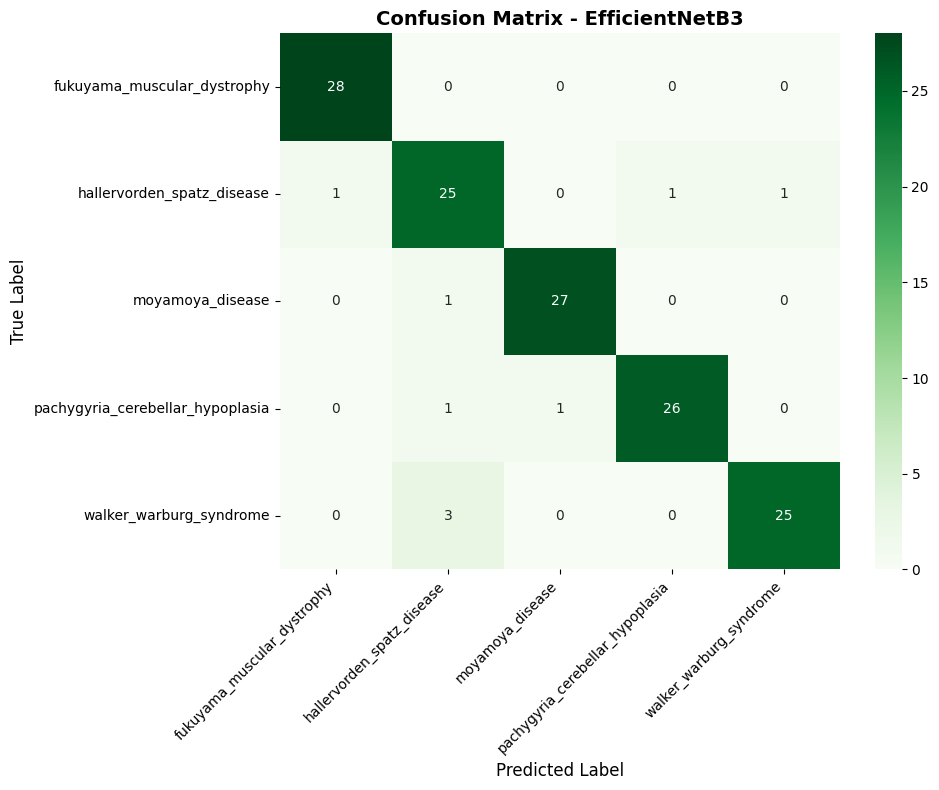

In [9]:
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - EfficientNetB3', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('efficientnetb3_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

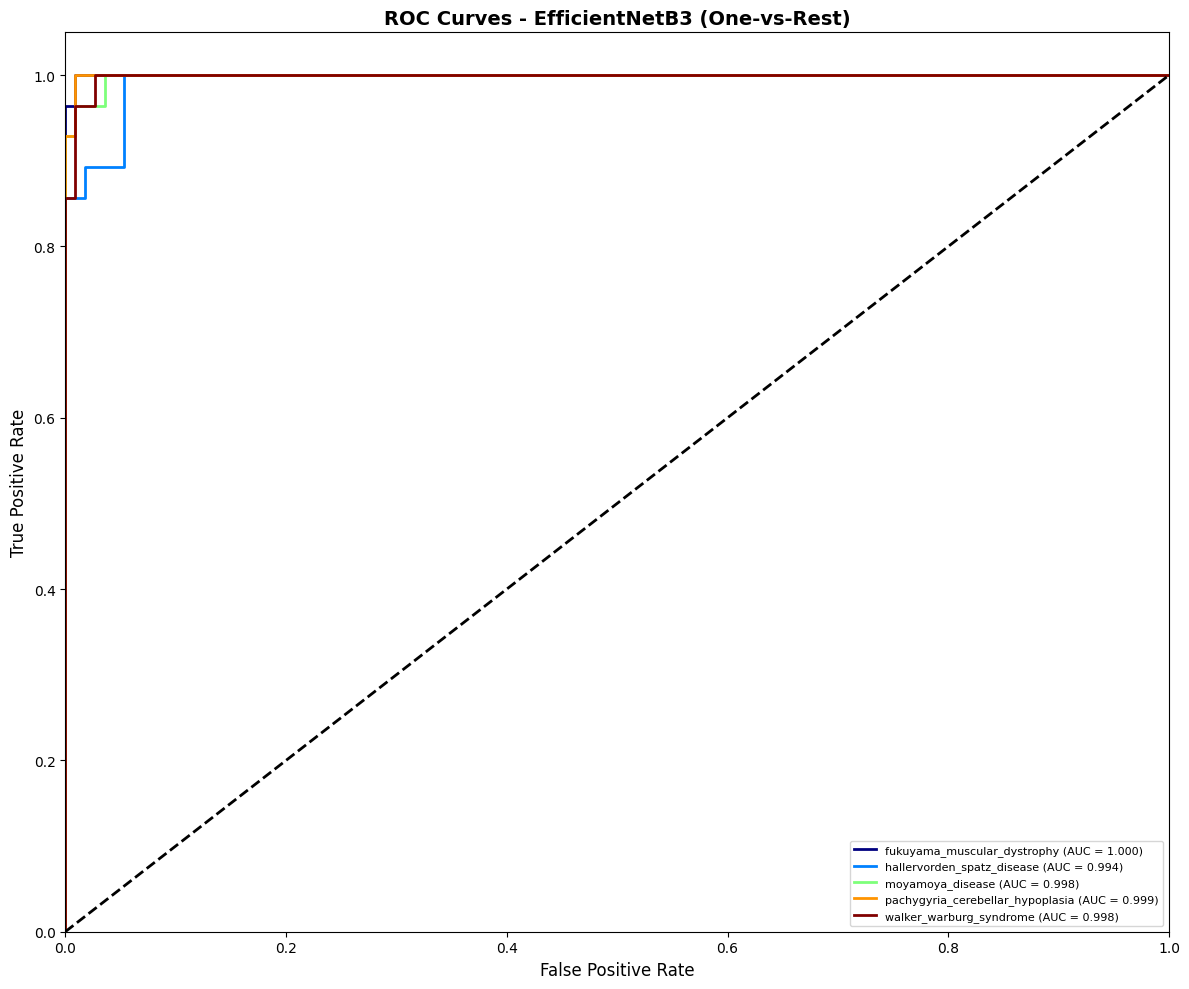

In [10]:
from sklearn.calibration import label_binarize
from sklearn.metrics import roc_curve, auc
y_true_bin = label_binarize(true_classes, classes=list(range(num_classes)))
y_score = predictions

plt.figure(figsize=(12, 10))
colors = plt.cm.jet(np.linspace(0, 1, num_classes))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - EfficientNetB3 (One-vs-Rest)', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=8)
plt.tight_layout()
plt.savefig('efficientnetb3_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

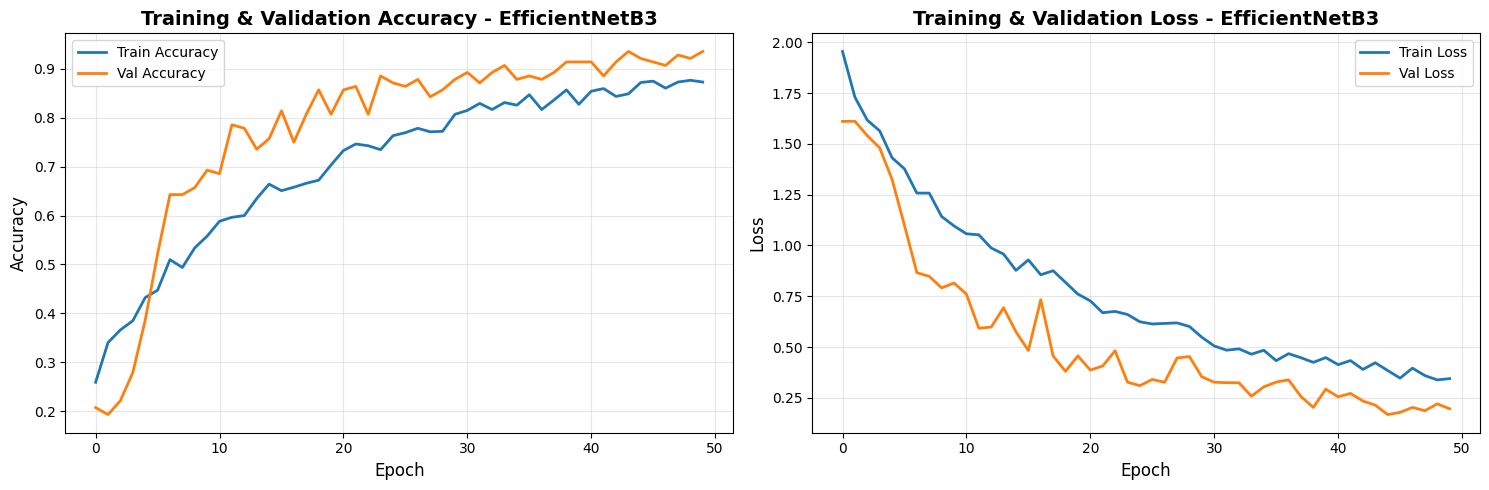

In [11]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Training & Validation Accuracy - EfficientNetB3', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training & Validation Loss - EfficientNetB3', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('efficientnetb3_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
model.save('efficientnetb3.h5')
print("\nModel saved as 'efficientnetb3.h5'")
print("Best model weights saved as 'best_efficientnetb3_tf_model.h5'")


Model saved as 'efficientnetb3.h5'
Best model weights saved as 'best_efficientnetb3_tf_model.h5'
